In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
InteractiveShell.ast_node_interactivity = "all"


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array

from scipy.signal import convolve2d
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution

In [2]:
df = pd.read_csv(r'/mnt/d/BusinessSuiteData/BS_epsilon_data/mmm_kubler_medium.csv', 
                 parse_dates=['Date'], 
                 index_col='Date')

In [3]:
df.head(3)

,TV,Radio,Banners,Sales
Date,,,,
2018-01-07,13528.1,0.00,0.00,9779.80
2018-01-14,0.0,5349.65,2218.93,13245.19
2018-01-21,0.0,4235.86,2046.96,12022.66


<center>Advertising Adstock</br>

    1. Saturating Effect/disminishing returns
    2. Carry over/ Lagged effect

Exponential Saturation

In [4]:
# Custom Exponential Saturation effect 

class ExponentialSaturation(BaseEstimator, TransformerMixin):
    
    def __init__(self, a=1.):
        self.a = a
        
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        
        return self
        
    def transform(self, X):
        
        check_is_fitted(self)
        
        X = check_array(X)
        
        self._check_n_features(X, reset=False)
        
        return 1 - np.exp(-self.a*X)

In [5]:
# Example

ExponentialSaturation(a = 0.01).fit_transform(pd.DataFrame([100, 50, 30, 120, 9001, 5, 0, 80]))

array([[0.63212056],
       [0.39346934],
       [0.25918178],
       [0.69880579],
       [1.        ],
       [0.04877058],
       [0.        ],
       [0.55067104]])

Carry-Over Effect

In [6]:
# Custom Carry Over effect

# Note : spicy's convulution function helps apprehend the 'tail'/delay of advertising

class ExponentialCarryOver(BaseEstimator, TransformerMixin):
    
    def __init__(self, strength=0.5, length=1):
        self.strength = strength 
        self.length = length 
        
    def fit(self, X, y=None):
        
        X = check_array(X)
        self._check_n_features(X, reset=True)
        self.sliding_window_ = (self.strength ** np.arange(self.length + 1)).reshape(-1, 1)
        
        return self 
    
    
    def transform(self, X: np.ndarray):
        
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        
        convolution = convolve2d(X, self.sliding_window_)
        
        if self.length > 0:
            convolution = convolution[: -self.length]
            
        return convolution

Pipelines & Model

In [7]:
# Adstock Pipeline with one couple custom estimators (above) for each channel

adstock = \
    ColumnTransformer(
        [('tv_pipe', Pipeline([('carryover', ExponentialCarryOver()), ('saturation', ExponentialSaturation())]) , ['TV']),
        ('radio_pipe', Pipeline([('carryover', ExponentialCarryOver()), ('saturation', ExponentialSaturation())]) , ['Radio']),
        ('banners_pipe', Pipeline([('carryover', ExponentialCarryOver()), ('saturation', ExponentialSaturation())]) , ['Banners'])],
        remainder='passthrough'
    )

In [8]:
# Model set up

model = Pipeline([
                  ('adstock', adstock),
                  ('regression', LinearRegression())
        ])

In [9]:
# X, Y set up

X = df.drop(columns=['Sales'])
y = df['Sales']

<center>Modeling

In [10]:
# Model without fine tuning

cross_val_score(model, X, y, cv=TimeSeriesSplit()).mean()

0.552719007323667

In [ ]:
# Fine tune the model (the output has been deleted)

tuned_model = \
    OptunaSearchCV(
        estimator=model,
        param_distributions={
            'adstock__tv_pipe__carryover__strength': FloatDistribution(0, 1),
            'adstock__tv_pipe__carryover__length': IntDistribution(0, 6),
            'adstock__tv_pipe__saturation__a': FloatDistribution(0, 0.01),
            'adstock__radio_pipe__carryover__strength': FloatDistribution(0, 1),
            'adstock__radio_pipe__carryover__length': IntDistribution(0, 6),
            'adstock__radio_pipe__saturation__a': FloatDistribution(0, 0.01),
            'adstock__banners_pipe__carryover__strength': FloatDistribution(0, 1),
            'adstock__banners_pipe__carryover__length': IntDistribution(0, 6),
            'adstock__banners_pipe__saturation__a': FloatDistribution(0, 0.01),
        },
        n_trials=1000,
        cv=TimeSeriesSplit(),
        random_state=0)

In [ ]:
# Fit the model (the output has been deleted)

tuned_model.fit(X, y)

In [13]:
# Cross val score of the fitted model

cross_val_score(tuned_model.best_estimator_, X, y, cv=TimeSeriesSplit()).mean()

0.9340874940105468

In [14]:
# Best Parameters of the model

tuned_model.best_params_

{'adstock__tv_pipe__carryover__strength': 0.5248878517291329,
 'adstock__tv_pipe__carryover__length': 4,
 'adstock__tv_pipe__saturation__a': 1.4649722346562529e-05,
 'adstock__radio_pipe__carryover__strength': 0.45523455448406197,
 'adstock__radio_pipe__carryover__length': 0,
 'adstock__radio_pipe__saturation__a': 0.0001974038926379962,
 'adstock__banners_pipe__carryover__strength': 0.3340342963936898,
 'adstock__banners_pipe__carryover__length': 0,
 'adstock__banners_pipe__saturation__a': 0.007256873558015173}

In [15]:
# Coefficients of the linear regression

tuned_model.best_estimator_.named_steps['regression'].coef_

array([27926.6810003 ,  4114.46117033,  2537.18883927])

In [16]:
# Baseline (the 'natural' sales whithout advertising)

tuned_model.best_estimator_.named_steps['regression'].intercept_

5348.966158957057

<center>Model Interpretation

Saturation Effect

In [17]:
# Creates a saturation effect dataframe for further loggings

saturation_effects_df = pd.DataFrame([i for i in range(0,15000)], columns = ['spendings'])

saturation_effects_df.head(3)

,spendings
0,0
1,1
2,2


In [18]:
# Commits the tv saturation to saturation_effects_df

saturation_effects_df['tv_saturation'] = \
    ExponentialSaturation(a = tuned_model.best_params_['adstock__tv_pipe__saturation__a'])\
                                         .fit_transform(saturation_effects_df[['spendings']])

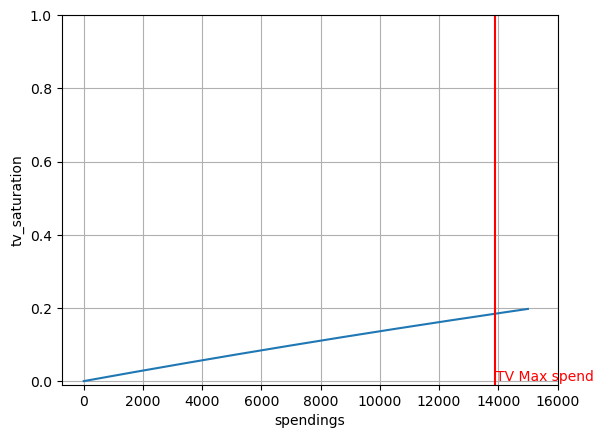

In [19]:
# Tv seems undersaturrated

sns.lineplot(data=saturation_effects_df, x = 'spendings', y = 'tv_saturation')

plt.ylim(None,1)
plt.xlim(None,16000)
plt.grid() 

plt.axvline(df['TV'].max(), color='r')

plt.text(df['TV'].max() + 10,0,'TV Max spend', color='red')
plt.show();

In [20]:
# Commits the radio saturation to saturation_effects_df

saturation_effects_df['radio_saturation'] = \
    ExponentialSaturation(a = tuned_model.best_params_['adstock__radio_pipe__saturation__a'])\
                                         .fit_transform(saturation_effects_df[['spendings']])

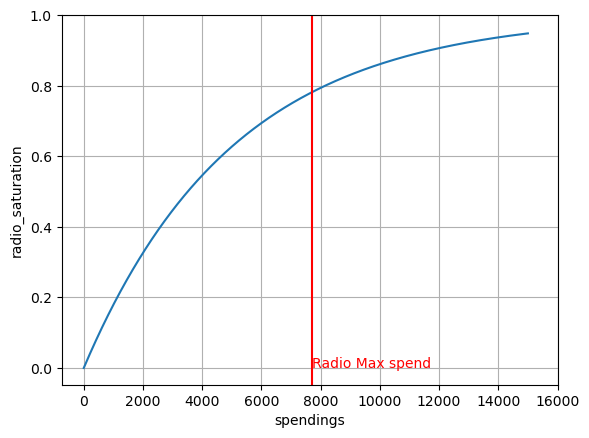

In [21]:
# Radio is undersaturated

sns.lineplot(data=saturation_effects_df, x = 'spendings', y = 'radio_saturation')

plt.ylim(None,1)
plt.xlim(None,16000)
plt.grid() 
plt.axvline(df['Radio'].max(), color='r')
plt.text(df['Radio'].max() + 10,0,'Radio Max spend', color='red')

plt.show();

In [22]:
# Commits the banners saturation to saturation_effects_df

saturation_effects_df['banners_saturation'] = \
    ExponentialSaturation(a = tuned_model.best_params_['adstock__banners_pipe__saturation__a'])\
                                         .fit_transform(saturation_effects_df[['spendings']])

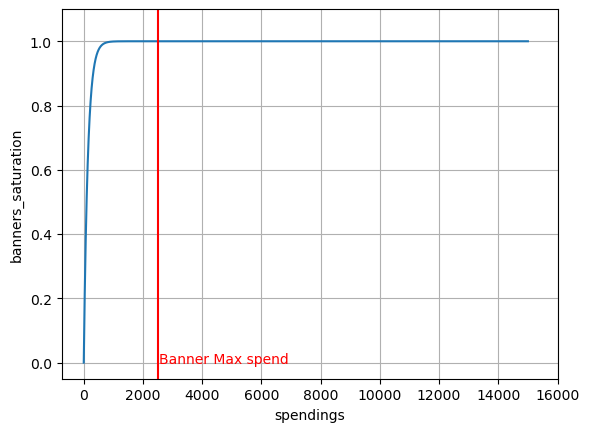

In [23]:
# Banner is saturated

sns.lineplot(data=saturation_effects_df, x = 'spendings', y = 'banners_saturation')

plt.ylim(None,1.1)
plt.xlim(None,16000)
plt.grid() 
plt.axvline(df['Banners'].max(), color='r')
plt.text(df['Banners'].max() + 10,0,'Banner Max spend', color='red')
plt.show();

Recommendations : 

    One can increase TV spendings as it is not saturated
    One can increase Radio spendings as it is not saturated (around the double of spendings could be profitable)
    One can decrease the Banner spendings as Banners are saturated

Carry Over effects 

In [24]:
# Retrieves the longest delay (in weeks) of the media advertsings 

max_delay = max(tuned_model.best_params_['adstock__banners_pipe__carryover__length'], 
                tuned_model.best_params_['adstock__radio_pipe__carryover__length'], 
                tuned_model.best_params_['adstock__tv_pipe__carryover__length']) \
            + 2 # For plot

In [25]:
# Defines a dataframe for further loggings

carry_over_effects_df = pd.DataFrame(index = [i for i in range(max_delay)], 
                                     columns = ['tv', 'radio', 'banners'])

carry_over_effects_df.head(3)

,tv,radio,banners
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN


In [26]:
# Commits the results inside carry_over_effects_df
# 100*(carryover strenght)^carryover lenght -- if exists

for j in ['tv', 'radio', 'banners']:
    for i in range(max_delay):
        if i <= tuned_model.best_params_['adstock__{}_pipe__carryover__length'.format(j)]:
            carry_over_effects_df.loc[i, [j]] = \
                100*(tuned_model.best_params_['adstock__{}_pipe__carryover__strength'.format(j)])**i
        else :
            carry_over_effects_df.loc[i, [j]] = 0

carry_over_effects_df.head(3)

,tv,radio,banners
0,100.0,100.0,100.0
1,52.488785,0,0
2,27.550726,0,0


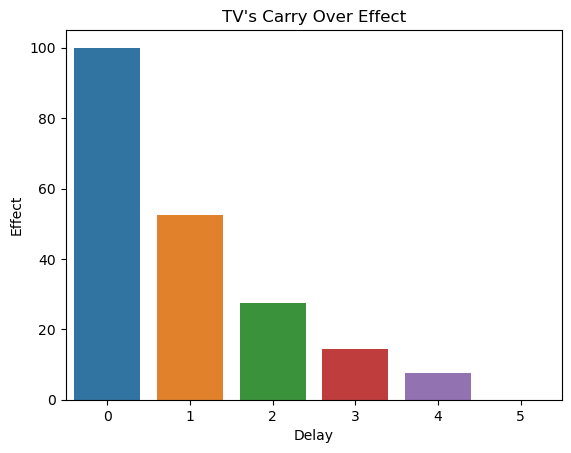

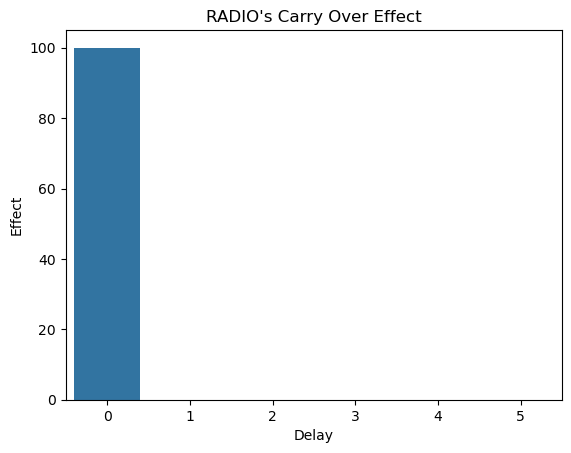

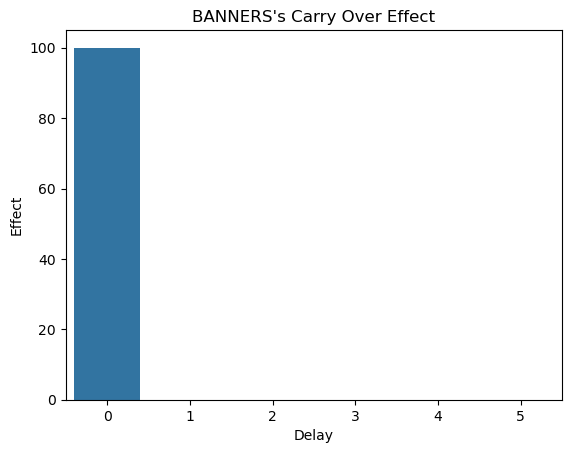

In [27]:
# Plots the carry over effects against delays (in weeks)

for i in ['tv', 'radio', 'banners']:
    sns.barplot(data = carry_over_effects_df, x = carry_over_effects_df.index, y = i)
    plt.title('{}\'s Carry Over Effect'.format(i.upper()))
    plt.ylabel('Effect')
    plt.xlabel('Delay')
    plt.show();
plt.show();

Recommendations : 
    
    Tv advertising has effects until 4 weeks later after initial spendings 
    Other spendings have effect only the week they are made

Channel Contributions

In [28]:
# Applies Exponential Carry Over and Stauration to the media features

ad_stock_data = \
    pd.DataFrame(tuned_model.best_estimator_.named_steps['adstock'].transform(X), 
                 columns=X.columns,
                 index=X.index)

ad_stock_data

,TV,Radio,Banners
Date,,,
2018-01-07,0.179780,0.000000,0.000000
2018-01-14,0.098796,0.652170,1.000000
2018-01-21,0.053137,0.566635,1.000000
2018-01-28,0.028253,0.504998,0.000000
2018-02-04,0.014930,0.000000,1.000000
...,...,...,...
2021-10-03,0.041749,0.000000,0.999995
2021-10-10,0.169183,0.597914,1.000000
2021-10-17,0.092703,0.593188,0.999999


In [29]:
# Sets up variables

weights = pd.Series(
    tuned_model.best_estimator_.named_steps['regression'].coef_,
    index=X.columns
)

weights

base = tuned_model.best_estimator_.named_steps['regression'].intercept_

base

# Note that the above transformation make the below weights much more consequent than in Pt. 1 

TV         27926.681000
Radio       4114.461170
Banners     2537.188839
dtype: float64

5348.966158957057

In [30]:
# Unadjusted contributions

unadj_contributions = ad_stock_data.mul(weights).assign(Base=base)

unadj_contributions.head(3)

,TV,Radio,Banners,Base
Date,,,,
2018-01-07,5020.663906,0.000000,0.000000,5348.966159
2018-01-14,2759.048639,2683.328585,2537.188582,5348.966159
2018-01-21,1483.939148,2331.398245,2537.187942,5348.966159


In [31]:
# Adjusted contributions

adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

adj_contributions.head(3)

,TV,Radio,Banners,Base
Date,,,,
2018-01-07,4735.085877,0.000000,0.000000,5044.714123
2018-01-14,2741.796586,2666.550002,2521.323798,5315.519614
2018-01-21,1524.668530,2395.387668,2606.825634,5495.778168


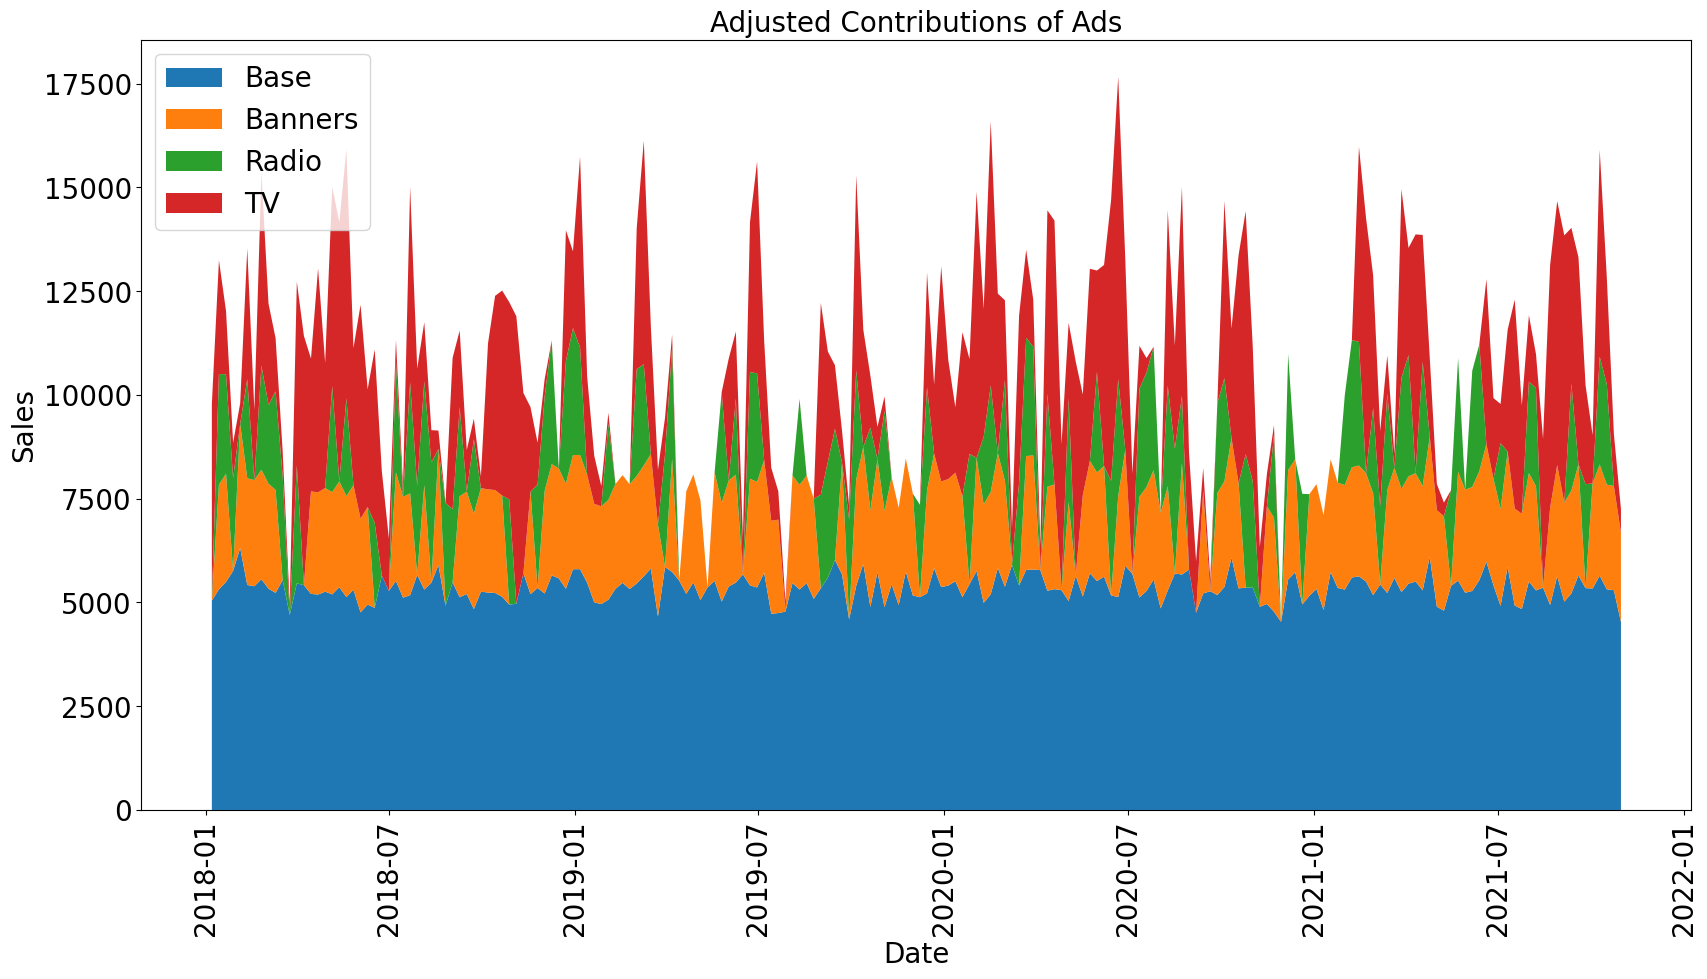

In [32]:
# Plots Adjusted Contributions of Ads

fig, ax = plt.subplots(figsize=(20,10))

plt.stackplot(adj_contributions.index, 
              adj_contributions['Base'],
              adj_contributions['Banners'],
              adj_contributions['Radio'],
              adj_contributions['TV'], 
             labels = ['Base', 'Banners', 'Radio', 'TV'])

plt.xticks(rotation=90)

plt.title('Adjusted Contributions of Ads', fontsize=20)

plt.legend(loc='upper left', fontsize=20)

plt.xlabel('Date', fontsize=20)
plt.ylabel('Sales', fontsize=20)

ax.tick_params(axis='both', labelsize=20)

plt.show();

<center>Return On Investment

In [33]:
# Channel ROI = Sales from the channel / Channel spendings

print('TV ROI : ', adj_contributions['TV'].sum()/df['TV'].sum(), '$')
print('Banners ROI : ', adj_contributions['Banners'].sum()/df['Banners'].sum(), '$')
print('Radio ROI : ', adj_contributions['Radio'].sum()/df['Radio'].sum(), '$')

TV ROI :  0.7635676892819867 $
Banners ROI :  1.2673390586533413 $
Radio ROI :  0.51737967272046 $
